In [1]:
# !pip install torchvision

In [2]:
# import numpy as np
# print(np.__version__)

In [3]:
# !pip uninstall numpy opencv-python -y
# !pip install --upgrade "numpy==1.23.5"
# !pip install --upgrade "scikit-image<0.25"
# !pip install --no-deps opencv-python

In [4]:
# !pip uninstall typing_extensions
# !pip install typing_extensions==4.11.0

In [5]:
!pip install typing_extensions>=4.3 --upgrade

In [6]:
# !pip install --upgrade pydantic

In [7]:
!pip install typing_extensions==4.12.2 --upgrade
# pip install typing_extensions==4.7.1 --upgrade

Defaulting to user installation because normal site-packages is not writeable
  Using cached typing_extensions-4.12.2-py3-none-any.whl (37 kB)
  Attempting uninstall: typing_extensions
    Found existing installation: typing_extensions 4.13.2
    Uninstalling typing_extensions-4.13.2:
      Successfully uninstalled typing_extensions-4.13.2


In [8]:
from typing_extensions import TypeIs

**Preprocessing - flipping, resizing, rotation, intensity based transformation**

In [9]:
import os
import numpy as np
from torchvision import transforms
from torchvision.transforms import functional as TF
from torch.utils.data import Dataset, DataLoader, random_split
from PIL import Image

# Custom joint transformation that applies geometric transforms to both image and mask,
# and intensity transforms only to the image.
class JointTransform:
    def __init__(self, resize=(256, 256), rotation=20, hflip_prob=0.5, vflip_prob=0.5,
                 intensity_transforms=None):
        self.resize = resize
        self.rotation = rotation
        self.hflip_prob = hflip_prob
        self.vflip_prob = vflip_prob
        # Intensity transforms should be a torchvision transform applied only to the image.
        # For example, transforms.Compose([transforms.ColorJitter(brightness=0.2, contrast=0.2),
        #                                  transforms.Lambda(lambda x: x.pow(0.5))])
        self.intensity_transforms = intensity_transforms

    def __call__(self, image, mask):
        # 1. Resize both image and mask
        image = TF.resize(image, self.resize)
        mask = TF.resize(mask, self.resize)
        
        # 2. Random horizontal flip
        if np.random.rand() < self.hflip_prob:
            image = TF.hflip(image)
            mask = TF.hflip(mask)
            
        # 3. Random vertical flip
        if np.random.rand() < self.vflip_prob:
            image = TF.vflip(image)
            mask = TF.vflip(mask)
            
        # 4. Random rotation
        angle = np.random.uniform(-self.rotation, self.rotation)
        image = TF.rotate(image, angle, interpolation=Image.BILINEAR)
        # For masks, use nearest neighbor interpolation to preserve label boundaries.
        mask = TF.rotate(mask, angle, interpolation=Image.NEAREST)
        
        # 5. Apply intensity transforms to the image only (if provided)
        if self.intensity_transforms:
            image = self.intensity_transforms(image)
        
        # 6. Convert both image and mask to tensor
        image = TF.to_tensor(image)
        mask = TF.to_tensor(mask)
        # Optionally ensure the mask is binary
        mask = (mask > 0.5).float()
        
        return image, mask

# Define intensity-only transformations for the image.
intensity_transforms = transforms.Compose([
    transforms.ColorJitter(brightness=0.2, contrast=0.2),
#     transforms.Lambda(lambda x: TF.adjust_gamma(x, 0.5))  # Gamma correction with gamma=0.5
])

# Create the joint transformation instance
joint_transform = JointTransform(resize=(256, 256), rotation=20,
                                 hflip_prob=0.5, vflip_prob=0.5,
                                 intensity_transforms=intensity_transforms)

class CustomDataset(Dataset):
    def __init__(self, image_dir, mask_dir, joint_transform=None):
        self.image_dir = image_dir
        self.mask_dir = mask_dir
        self.joint_transform = joint_transform
        # Sort the file lists to ensure alignment between images and masks
        self.images = sorted([os.path.join(image_dir, x) for x in os.listdir(image_dir) if x.endswith('.png')])
        self.masks = sorted([os.path.join(mask_dir, x) for x in os.listdir(mask_dir) if 'Annotation' in x])

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        image_path = self.images[idx]
        mask_path = self.masks[idx]
        image = Image.open(image_path).convert("RGB")
        mask = Image.open(mask_path).convert("L")
        
        if self.joint_transform:
            image, mask = self.joint_transform(image, mask)
        return image, mask

# Initialize dataset with the joint transform
full_dataset = CustomDataset('denoised_training_set', 'masked_annotations', joint_transform=joint_transform)

# Splitting the dataset into train and validation sets
# train_size = int(0.8 * len(full_dataset))
# validation_size = len(full_dataset) - train_size
# train_dataset, validation_dataset = random_split(full_dataset, [train_size, validation_size])

# # Create separate dataloaders for train and validation datasets
# train_loader = DataLoader(train_dataset, batch_size=10, shuffle=True)
# validation_loader = DataLoader(validation_dataset, batch_size=10, shuffle=False)

In [10]:
# for i in range(5):
#     img, mask = full_dataset[i]
#     print(f"Sample {i}:")
#     print("  Image type:", type(img), "shape:", img.shape, "dtype:", img.dtype)
#     print("  Mask type:", type(mask), "shape:", mask.shape, "dtype:", mask.dtype)


In [11]:
print("Total number of data samples:", len(full_dataset))

Total number of data samples: 749


**Checking alignment and order of train image and the corresponding masking**

In [12]:
for img_path, mask_path in zip(sorted(os.listdir('denoised_training_set')), 
                               sorted(os.listdir('masked_annotations'))):
    if img_path.endswith('.png') and 'Annotation' in mask_path:
        base_img = os.path.splitext(img_path)[0]
        base_mask = os.path.splitext(mask_path)[0].replace('_Annotation', '')
        assert base_img == base_mask, f"Mismatch: {base_img} vs {base_mask}"


**Unet with resnet101 as backbone**

In [13]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision import models

class ResConv(nn.Module):
    """ Convolution block for U-Net with repeated convolutions and ReLU activations. """
    def __init__(self, in_ch, out_ch):
        super(ResConv, self).__init__()
        self.conv = nn.Sequential(
            nn.Conv2d(in_ch, out_ch, 3, padding=1),
            nn.BatchNorm2d(out_ch),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_ch, out_ch, 3, padding=1),
            nn.BatchNorm2d(out_ch),
            nn.ReLU(inplace=True)
        )

    def forward(self, x):
        return self.conv(x)

class UpConv(nn.Module):
    """ Upsampling block for U-Net, using bilinear interpolation and convolution. """
    def __init__(self, in_ch, out_ch):
        super(UpConv, self).__init__()
        self.up = nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True)
        self.conv = ResConv(in_ch, out_ch)

    def forward(self, from_down, from_up):
        from_up = self.up(from_up)
        diffY = from_down.size()[2] - from_up.size()[2]
        diffX = from_down.size()[3] - from_up.size()[3]
        from_up = F.pad(from_up, [diffX // 2, diffX - diffX // 2,
                                  diffY // 2, diffY - diffY // 2])
        x = torch.cat([from_down, from_up], dim=1)
        return self.conv(x)

class UNetResNet101(nn.Module):
    def __init__(self, n_classes=1):
        super(UNetResNet101, self).__init__()
        base_model = models.resnet101(pretrained=True)
        self.base_layers = list(base_model.children())
        
        # Extract layers from ResNet101
        self.layer0 = nn.Sequential(*self.base_layers[:3])  # conv1, bn1, relu
        self.maxpool = self.base_layers[3]
        self.layer1 = self.base_layers[4]  # Output: 256 channels
        self.layer2 = self.base_layers[5]  # Output: 512 channels
        self.layer3 = self.base_layers[6]  # Output: 1024 channels
        self.layer4 = self.base_layers[7]  # Output: 2048 channels

        # Decoder (make sure the channel numbers match the skip connection outputs)
        self.up4 = UpConv(2048 + 1024, 1024)  # Concatenating x3 (1024) and x4 (2048) -> 3072 channels
        self.up3 = UpConv(1024 + 512, 512)    # Concatenating x2 (512) and previous output (1024) -> 1536 channels
        self.up2 = UpConv(512 + 256, 256)     # Concatenating x1 (256) and previous output (512) -> 768 channels
        self.up1 = UpConv(256 + 64, 64)       # Concatenating x0 (64) and previous output (256) -> 320 channels

        # Final upsampling and output convolution to match input size
        self.final_up = nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True)
        self.final_conv = nn.Conv2d(64, n_classes, kernel_size=1)

    def forward(self, x):
        # Encoder: get intermediate features for skip connections
        x0 = self.layer0(x)       # Early features, e.g., 64 channels
        x1 = self.maxpool(x0)
        x1 = self.layer1(x1)      # 256 channels
        x2 = self.layer2(x1)      # 512 channels
        x3 = self.layer3(x2)      # 1024 channels
        x4 = self.layer4(x3)      # 2048 channels

        # Decoder: use skip connections from intermediate features
        x = self.up4(x3, x4)      # Upsample: x3 (from_down) + x4 (from_up)
        x = self.up3(x2, x)       # Upsample: x2 + output of previous block
        x = self.up2(x1, x)       # Upsample: x1 + output of previous block
        x = self.up1(x0, x)       # Upsample: x0 + output of previous block

        x = self.final_up(x)      # Final upsampling to the original size
        x = self.final_conv(x)
        return torch.sigmoid(x)

**Dice loss + Binary cross-entropy loss**

In [14]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class DiceBCELoss(nn.Module):
    def __init__(self):
        super().__init__()

    def forward(self, inputs, targets, smooth=1):
        inputs = inputs.view(-1)
        targets = targets.view(-1)
        intersection = (inputs * targets).sum()
        dice_loss   = 1 - (2.*intersection + smooth)/(inputs.sum() + targets.sum() + smooth)
        bce = F.binary_cross_entropy(inputs, targets, reduction='mean')
        return bce + dice_loss

class BoundaryLoss(nn.Module):
    def __init__(self):
        super().__init__()

    def forward(self, inputs, targets):
        # inputs, targets: (B,1,H,W) probabilities and binaries
        # compute morphological gradient: max_pool – min_pool
        max_t = F.max_pool2d(targets, kernel_size=3, stride=1, padding=1)
        min_t = -F.max_pool2d(-targets, kernel_size=3, stride=1, padding=1)
        bd_t  = max_t - min_t

        max_p = F.max_pool2d(inputs, kernel_size=3, stride=1, padding=1)
        min_p = -F.max_pool2d(-inputs, kernel_size=3, stride=1, padding=1)
        bd_p  = max_p - min_p

        # L1 on the boundary maps
        return F.l1_loss(bd_p, bd_t)

class DiceBCEBoundaryLoss(nn.Module):
    def __init__(self, boundary_weight=0.5):
        super().__init__()
        self.seg_loss     = DiceBCELoss()
        self.boundary_loss= BoundaryLoss()
        self.boundary_w   = boundary_weight

    def forward(self, inputs, targets):
        seg = self.seg_loss(inputs, targets)
        bnd = self.boundary_loss(inputs, targets)
        return seg + self.boundary_w * bnd

**Training Loop**

In [15]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

Using device: cuda:0


In [16]:
import os
import torch
import torch.optim as optimizer
from torch.optim.lr_scheduler import ReduceLROnPlateau
import numpy as np
from sklearn.metrics import f1_score
from sklearn.model_selection import KFold
from torch.utils.data import DataLoader, Subset
import matplotlib.pyplot as plt
import cv2

# Assume full_dataset, device, UNetResNet101, DiceBCELoss, and joint_transform are defined already.
# full_dataset = CustomDataset('denoised_training_set', 'masked_annotations', joint_transform=joint_transform)

# Number of folds and training epochs
num_folds = 5
num_epochs = 50
patience = 5

# Set up KFold splitter
indices = np.arange(len(full_dataset))
kfold = KFold(n_splits=num_folds, shuffle=True, random_state=42)

# Folder to save overlay images (optional)
overlay_folder = 'overlay_images'
os.makedirs(overlay_folder, exist_ok=True)

# Helper function for overlay (as before)
def overlay_mask_on_image(image, mask, color=(255, 0, 0), alpha=0.4):
    color_mask = np.zeros_like(image)
    color_mask[mask == 255] = color
    overlay = cv2.addWeighted(image, 1 - alpha, color_mask, alpha, 0)
    return overlay

# Variables to track the best model overall (based on validation F1 score)
best_val_f1_overall = 0.0
best_model_state = None

# Begin cross-validation loop
for fold, (train_idx, val_idx) in enumerate(kfold.split(indices)):
    print(f"Starting fold {fold+1}/{num_folds}")
    
    # Create Subset datasets for current fold
    train_subset = Subset(full_dataset, train_idx)
    val_subset = Subset(full_dataset, val_idx)
    
    # Create dataloaders for current fold
    train_loader = DataLoader(train_subset, batch_size=10, shuffle=True)
    validation_loader = DataLoader(val_subset, batch_size=10, shuffle=False)
    
    # Reinitialize the model, loss, optimizer, and scheduler for each fold
    model = UNetResNet101().to(device)
    loss_function = DiceBCEBoundaryLoss(boundary_weight=0.5)
    optimizer = optim.Adam(model.parameters(), lr=1e-4)
    scheduler = ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=10, verbose=True)
    
    best_fold_val_f1 = -1.0
    early_stop_counter = 0
    
    for epoch in range(num_epochs):
        # Training phase
        model.train()
        running_loss = 0.0
        for images, masks in train_loader:
            images, masks = images.to(device), masks.to(device)
            optimizer.zero_grad()
            outputs = model(images)
            loss = loss_function(outputs, masks)
            
            loss.backward()
            optimizer.step()
            running_loss += loss.item()
        train_loss_epoch = running_loss / len(train_loader)
        
        # Evaluate training set for F1 score
        model.eval()
        all_train_preds = []
        all_train_targets = []
        with torch.no_grad():
            for images, masks in train_loader:
                images, masks = images.to(device), masks.to(device)
                
                outputs = model(images)
                preds = (outputs > 0.5).float()
                binary_masks = (masks > 0.5).float()
                
                all_train_preds.append(preds.cpu().numpy().flatten())
                all_train_targets.append(binary_masks.cpu().numpy().flatten())
        all_train_preds = np.concatenate(all_train_preds)
        all_train_targets = np.concatenate(all_train_targets)
        train_f1 = f1_score(all_train_targets, all_train_preds)
        
        # Evaluate validation set
        val_loss = 0.0
        all_val_preds = []
        all_val_targets = []
        with torch.no_grad():
            for images, masks in validation_loader:
                images, masks = images.to(device), masks.to(device)
                outputs = model(images)
                loss = loss_function(outputs, masks)
                val_loss += loss.item()
                preds = (outputs > 0.5).float()
                binary_masks = (masks > 0.5).float()
                all_val_preds.append(preds.cpu().numpy().flatten())
                all_val_targets.append(binary_masks.cpu().numpy().flatten())
        all_val_preds = np.concatenate(all_val_preds)
        all_val_targets = np.concatenate(all_val_targets)
        val_f1 = f1_score(all_val_targets, all_val_preds)
        val_loss_epoch = val_loss / len(validation_loader)
        
        print(f"Fold {fold+1}, Epoch {epoch+1}/{num_epochs}, "
              f"Train Loss: {train_loss_epoch:.4f}, Train F1: {train_f1:.4f}, "
              f"Val Loss: {val_loss_epoch:.4f}, Val F1: {val_f1:.4f}")
        
        # Adjust learning rate based on validation loss
        scheduler.step(val_loss_epoch)
        
        # If current validation F1 is best so far, update best model state across folds/epochs
        if val_f1 > best_val_f1_overall:
            best_val_f1_overall = val_f1
            best_model_state = model.state_dict()
            
        # Early stopping for current fold: check if current validation F1 improved over best_fold_val_f1
        if val_f1 > best_fold_val_f1:
            best_fold_val_f1 = val_f1
            early_stop_counter = 0
        else:
            early_stop_counter += 1
        
        if early_stop_counter >= patience:
            print(f"Early stopping triggered in fold {fold+1} at epoch {epoch+1}")
            break
        
        # Optionally, every 10 epochs, save an overlay visualization from validation
        if (epoch + 1) % 10 == 0:
            with torch.no_grad():
                for images, _ in validation_loader:
                    images = images.to(device)
                    outputs = model(images)
                    preds = (outputs > 0.5).float()
                    img_tensor = images[0].cpu()  # first image from the batch
                    pred_tensor = preds[0].cpu()  # corresponding prediction
                    img_np = img_tensor.permute(1, 2, 0).numpy()
                    img_uint8 = (img_np * 255).astype(np.uint8)
                    mask_np = pred_tensor.squeeze().numpy()
                    mask_uint8 = (mask_np * 255).astype(np.uint8)
                    overlay_img = overlay_mask_on_image(img_uint8, mask_uint8, color=(255, 0, 0), alpha=0.4)
                    # Convert to BGR for cv2.imwrite
                    overlay_bgr = cv2.cvtColor(overlay_img, cv2.COLOR_RGB2BGR)
                    overlay_save_path = os.path.join(overlay_folder, f'fold{fold+1}_epoch{epoch+1}.png')
                    cv2.imwrite(overlay_save_path, overlay_bgr)
                    print(f"Saved overlay image at: {overlay_save_path}")
                    break  # Process only one batch for overlay visualization

# After all folds, save the best model
if best_model_state is not None:
    torch.save(best_model_state, 'best_unet_resnet101_model.pth')
    print(f"Best model saved with validation F1: {best_val_f1_overall:.4f}")
else:
    print("No model was saved.")

Starting fold 1/5


/usr/lib/python3/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/lib/python3/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet101_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet101_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
/usr/lib/python3/dist-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


Fold 1, Epoch 1/50, Train Loss: 0.5817, Train F1: 0.9583, Val Loss: 0.4886, Val F1: 0.9571
Fold 1, Epoch 2/50, Train Loss: 0.4321, Train F1: 0.9682, Val Loss: 0.4138, Val F1: 0.9630
Fold 1, Epoch 3/50, Train Loss: 0.3668, Train F1: 0.9714, Val Loss: 0.3447, Val F1: 0.9704
Fold 1, Epoch 4/50, Train Loss: 0.3311, Train F1: 0.9700, Val Loss: 0.3174, Val F1: 0.9691
Fold 1, Epoch 5/50, Train Loss: 0.2864, Train F1: 0.9744, Val Loss: 0.2831, Val F1: 0.9718
Fold 1, Epoch 6/50, Train Loss: 0.2585, Train F1: 0.9751, Val Loss: 0.2608, Val F1: 0.9710
Fold 1, Epoch 7/50, Train Loss: 0.2341, Train F1: 0.9759, Val Loss: 0.2273, Val F1: 0.9734
Fold 1, Epoch 8/50, Train Loss: 0.2116, Train F1: 0.9761, Val Loss: 0.2107, Val F1: 0.9742
Fold 1, Epoch 9/50, Train Loss: 0.1957, Train F1: 0.9765, Val Loss: 0.1984, Val F1: 0.9752
Fold 1, Epoch 10/50, Train Loss: 0.1782, Train F1: 0.9764, Val Loss: 0.1811, Val F1: 0.9739
Saved overlay image at: overlay_images/fold1_epoch10.png
Fold 1, Epoch 11/50, Train Loss:

/usr/lib/python3/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/lib/python3/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet101_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet101_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
/usr/lib/python3/dist-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


Fold 2, Epoch 1/50, Train Loss: 0.7224, Train F1: 0.8930, Val Loss: 0.6952, Val F1: 0.8895
Fold 2, Epoch 2/50, Train Loss: 0.5740, Train F1: 0.9653, Val Loss: 0.5789, Val F1: 0.9627
Fold 2, Epoch 3/50, Train Loss: 0.5145, Train F1: 0.9680, Val Loss: 0.5073, Val F1: 0.9652
Fold 2, Epoch 4/50, Train Loss: 0.4642, Train F1: 0.9654, Val Loss: 0.4723, Val F1: 0.9616
Fold 2, Epoch 5/50, Train Loss: 0.4177, Train F1: 0.9714, Val Loss: 0.4101, Val F1: 0.9681
Fold 2, Epoch 6/50, Train Loss: 0.3816, Train F1: 0.9749, Val Loss: 0.3783, Val F1: 0.9722
Fold 2, Epoch 7/50, Train Loss: 0.3466, Train F1: 0.9751, Val Loss: 0.3507, Val F1: 0.9727
Fold 2, Epoch 8/50, Train Loss: 0.3172, Train F1: 0.9765, Val Loss: 0.3237, Val F1: 0.9727
Fold 2, Epoch 9/50, Train Loss: 0.2919, Train F1: 0.9708, Val Loss: 0.3048, Val F1: 0.9667
Fold 2, Epoch 10/50, Train Loss: 0.2739, Train F1: 0.9765, Val Loss: 0.2754, Val F1: 0.9726
Saved overlay image at: overlay_images/fold2_epoch10.png
Fold 2, Epoch 11/50, Train Loss:

/usr/lib/python3/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/lib/python3/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet101_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet101_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
/usr/lib/python3/dist-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


Fold 3, Epoch 1/50, Train Loss: 0.5439, Train F1: 0.9574, Val Loss: 0.4625, Val F1: 0.9541
Fold 3, Epoch 2/50, Train Loss: 0.3919, Train F1: 0.9694, Val Loss: 0.3712, Val F1: 0.9673
Fold 3, Epoch 3/50, Train Loss: 0.3399, Train F1: 0.9726, Val Loss: 0.3358, Val F1: 0.9699
Fold 3, Epoch 4/50, Train Loss: 0.2965, Train F1: 0.9696, Val Loss: 0.2961, Val F1: 0.9688
Fold 3, Epoch 5/50, Train Loss: 0.2641, Train F1: 0.9753, Val Loss: 0.2595, Val F1: 0.9732
Fold 3, Epoch 6/50, Train Loss: 0.2387, Train F1: 0.9746, Val Loss: 0.2446, Val F1: 0.9726
Fold 3, Epoch 7/50, Train Loss: 0.2168, Train F1: 0.9778, Val Loss: 0.2200, Val F1: 0.9749
Fold 3, Epoch 8/50, Train Loss: 0.2011, Train F1: 0.9765, Val Loss: 0.2066, Val F1: 0.9735
Fold 3, Epoch 9/50, Train Loss: 0.1849, Train F1: 0.9765, Val Loss: 0.1951, Val F1: 0.9743
Fold 3, Epoch 10/50, Train Loss: 0.1724, Train F1: 0.9745, Val Loss: 0.1827, Val F1: 0.9721
Saved overlay image at: overlay_images/fold3_epoch10.png
Fold 3, Epoch 11/50, Train Loss:

/usr/lib/python3/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/lib/python3/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet101_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet101_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
/usr/lib/python3/dist-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


Fold 4, Epoch 1/50, Train Loss: 0.5747, Train F1: 0.9571, Val Loss: 0.4262, Val F1: 0.9611
Fold 4, Epoch 2/50, Train Loss: 0.4206, Train F1: 0.9665, Val Loss: 0.3819, Val F1: 0.9682
Fold 4, Epoch 3/50, Train Loss: 0.3725, Train F1: 0.9703, Val Loss: 0.3390, Val F1: 0.9700
Fold 4, Epoch 4/50, Train Loss: 0.3303, Train F1: 0.9737, Val Loss: 0.2983, Val F1: 0.9746
Fold 4, Epoch 5/50, Train Loss: 0.3005, Train F1: 0.9688, Val Loss: 0.2887, Val F1: 0.9705
Fold 4, Epoch 6/50, Train Loss: 0.2769, Train F1: 0.9706, Val Loss: 0.2544, Val F1: 0.9717
Fold 4, Epoch 7/50, Train Loss: 0.2522, Train F1: 0.9768, Val Loss: 0.2379, Val F1: 0.9763
Fold 4, Epoch 8/50, Train Loss: 0.2253, Train F1: 0.9756, Val Loss: 0.2070, Val F1: 0.9753
Fold 4, Epoch 9/50, Train Loss: 0.2108, Train F1: 0.9759, Val Loss: 0.1883, Val F1: 0.9757
Fold 4, Epoch 10/50, Train Loss: 0.1957, Train F1: 0.9768, Val Loss: 0.1872, Val F1: 0.9760
Saved overlay image at: overlay_images/fold4_epoch10.png
Fold 4, Epoch 11/50, Train Loss:

/usr/lib/python3/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/lib/python3/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet101_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet101_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
/usr/lib/python3/dist-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


Fold 5, Epoch 1/50, Train Loss: 0.5539, Train F1: 0.9539, Val Loss: 0.4672, Val F1: 0.9545
Fold 5, Epoch 2/50, Train Loss: 0.4052, Train F1: 0.9689, Val Loss: 0.3883, Val F1: 0.9671
Fold 5, Epoch 3/50, Train Loss: 0.3537, Train F1: 0.9711, Val Loss: 0.3555, Val F1: 0.9689
Fold 5, Epoch 4/50, Train Loss: 0.3131, Train F1: 0.9736, Val Loss: 0.3128, Val F1: 0.9718
Fold 5, Epoch 5/50, Train Loss: 0.2802, Train F1: 0.9752, Val Loss: 0.2844, Val F1: 0.9728
Fold 5, Epoch 6/50, Train Loss: 0.2537, Train F1: 0.9757, Val Loss: 0.2599, Val F1: 0.9735
Fold 5, Epoch 7/50, Train Loss: 0.2312, Train F1: 0.9772, Val Loss: 0.2412, Val F1: 0.9747
Fold 5, Epoch 8/50, Train Loss: 0.2096, Train F1: 0.9747, Val Loss: 0.2219, Val F1: 0.9720
Fold 5, Epoch 9/50, Train Loss: 0.1953, Train F1: 0.9694, Val Loss: 0.2262, Val F1: 0.9668
Fold 5, Epoch 10/50, Train Loss: 0.1916, Train F1: 0.9628, Val Loss: 0.2222, Val F1: 0.9615
Saved overlay image at: overlay_images/fold5_epoch10.png
Fold 5, Epoch 11/50, Train Loss:

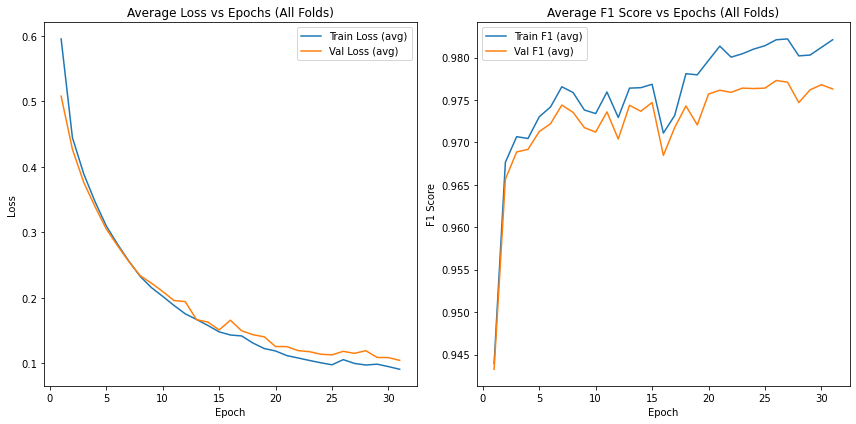

In [18]:
import re
import pandas as pd
import seaborn as sns

# Reuse full raw log data from user message (truncated earlier for demo)
# Let's simulate parsing the full log by expanding the regex extraction on the full multi-fold content
full_log_text = '''Starting fold 1/5
Fold 1, Epoch 1/50, Train Loss: 0.5817, Train F1: 0.9583, Val Loss: 0.4886, Val F1: 0.9571
Fold 1, Epoch 2/50, Train Loss: 0.4321, Train F1: 0.9682, Val Loss: 0.4138, Val F1: 0.9630
Fold 1, Epoch 3/50, Train Loss: 0.3668, Train F1: 0.9714, Val Loss: 0.3447, Val F1: 0.9704
Fold 1, Epoch 4/50, Train Loss: 0.3311, Train F1: 0.9700, Val Loss: 0.3174, Val F1: 0.9691
Fold 1, Epoch 5/50, Train Loss: 0.2864, Train F1: 0.9744, Val Loss: 0.2831, Val F1: 0.9718
Fold 1, Epoch 6/50, Train Loss: 0.2585, Train F1: 0.9751, Val Loss: 0.2608, Val F1: 0.9710
Fold 1, Epoch 7/50, Train Loss: 0.2341, Train F1: 0.9759, Val Loss: 0.2273, Val F1: 0.9734
Fold 1, Epoch 8/50, Train Loss: 0.2116, Train F1: 0.9761, Val Loss: 0.2107, Val F1: 0.9742
Fold 1, Epoch 9/50, Train Loss: 0.1957, Train F1: 0.9765, Val Loss: 0.1984, Val F1: 0.9752
Fold 1, Epoch 10/50, Train Loss: 0.1782, Train F1: 0.9764, Val Loss: 0.1811, Val F1: 0.9739
Saved overlay image at: overlay_images/fold1_epoch10.png
Fold 1, Epoch 11/50, Train Loss: 0.1682, Train F1: 0.9774, Val Loss: 0.1801, Val F1: 0.9743
Fold 1, Epoch 12/50, Train Loss: 0.1572, Train F1: 0.9762, Val Loss: 0.1675, Val F1: 0.9736
Fold 1, Epoch 13/50, Train Loss: 0.1481, Train F1: 0.9778, Val Loss: 0.1447, Val F1: 0.9758
Fold 1, Epoch 14/50, Train Loss: 0.1359, Train F1: 0.9770, Val Loss: 0.1478, Val F1: 0.9728
Fold 1, Epoch 15/50, Train Loss: 0.1288, Train F1: 0.9785, Val Loss: 0.1345, Val F1: 0.9761
Fold 1, Epoch 16/50, Train Loss: 0.1257, Train F1: 0.9781, Val Loss: 0.1388, Val F1: 0.9729
Fold 1, Epoch 17/50, Train Loss: 0.1435, Train F1: 0.9701, Val Loss: 0.1517, Val F1: 0.9700
Fold 1, Epoch 18/50, Train Loss: 0.1328, Train F1: 0.9736, Val Loss: 0.1411, Val F1: 0.9703
Fold 1, Epoch 19/50, Train Loss: 0.1199, Train F1: 0.9741, Val Loss: 0.1532, Val F1: 0.9646
Fold 1, Epoch 20/50, Train Loss: 0.1205, Train F1: 0.9763, Val Loss: 0.1224, Val F1: 0.9732
Early stopping triggered in fold 1 at epoch 20
Starting fold 2/5
Fold 2, Epoch 1/50, Train Loss: 0.7224, Train F1: 0.8930, Val Loss: 0.6952, Val F1: 0.8895
Fold 2, Epoch 2/50, Train Loss: 0.5740, Train F1: 0.9653, Val Loss: 0.5789, Val F1: 0.9627
Fold 2, Epoch 3/50, Train Loss: 0.5145, Train F1: 0.9680, Val Loss: 0.5073, Val F1: 0.9652
Fold 2, Epoch 4/50, Train Loss: 0.4642, Train F1: 0.9654, Val Loss: 0.4723, Val F1: 0.9616
Fold 2, Epoch 5/50, Train Loss: 0.4177, Train F1: 0.9714, Val Loss: 0.4101, Val F1: 0.9681
Fold 2, Epoch 6/50, Train Loss: 0.3816, Train F1: 0.9749, Val Loss: 0.3783, Val F1: 0.9722
Fold 2, Epoch 7/50, Train Loss: 0.3466, Train F1: 0.9751, Val Loss: 0.3507, Val F1: 0.9727
Fold 2, Epoch 8/50, Train Loss: 0.3172, Train F1: 0.9765, Val Loss: 0.3237, Val F1: 0.9727
Fold 2, Epoch 9/50, Train Loss: 0.2919, Train F1: 0.9708, Val Loss: 0.3048, Val F1: 0.9667
Fold 2, Epoch 10/50, Train Loss: 0.2739, Train F1: 0.9765, Val Loss: 0.2754, Val F1: 0.9726
Saved overlay image at: overlay_images/fold2_epoch10.png
Fold 2, Epoch 11/50, Train Loss: 0.2466, Train F1: 0.9778, Val Loss: 0.2543, Val F1: 0.9737
Fold 2, Epoch 12/50, Train Loss: 0.2366, Train F1: 0.9579, Val Loss: 0.3004, Val F1: 0.9557
Fold 2, Epoch 13/50, Train Loss: 0.2199, Train F1: 0.9763, Val Loss: 0.2097, Val F1: 0.9742
Fold 2, Epoch 14/50, Train Loss: 0.1986, Train F1: 0.9745, Val Loss: 0.2183, Val F1: 0.9713
Fold 2, Epoch 15/50, Train Loss: 0.1864, Train F1: 0.9770, Val Loss: 0.1927, Val F1: 0.9741
Fold 2, Epoch 16/50, Train Loss: 0.1722, Train F1: 0.9771, Val Loss: 0.1849, Val F1: 0.9740
Fold 2, Epoch 17/50, Train Loss: 0.1636, Train F1: 0.9792, Val Loss: 0.1672, Val F1: 0.9750
Fold 2, Epoch 18/50, Train Loss: 0.1518, Train F1: 0.9803, Val Loss: 0.1707, Val F1: 0.9763
Fold 2, Epoch 19/50, Train Loss: 0.1428, Train F1: 0.9792, Val Loss: 0.1523, Val F1: 0.9755
Fold 2, Epoch 20/50, Train Loss: 0.1355, Train F1: 0.9805, Val Loss: 0.1443, Val F1: 0.9765
Saved overlay image at: overlay_images/fold2_epoch20.png
Fold 2, Epoch 21/50, Train Loss: 0.1291, Train F1: 0.9809, Val Loss: 0.1379, Val F1: 0.9765
Fold 2, Epoch 22/50, Train Loss: 0.1242, Train F1: 0.9813, Val Loss: 0.1311, Val F1: 0.9768
Fold 2, Epoch 23/50, Train Loss: 0.1186, Train F1: 0.9796, Val Loss: 0.1310, Val F1: 0.9761
Fold 2, Epoch 24/50, Train Loss: 0.1136, Train F1: 0.9806, Val Loss: 0.1258, Val F1: 0.9764
Fold 2, Epoch 25/50, Train Loss: 0.1092, Train F1: 0.9811, Val Loss: 0.1252, Val F1: 0.9768
Fold 2, Epoch 26/50, Train Loss: 0.1057, Train F1: 0.9821, Val Loss: 0.1184, Val F1: 0.9773
Fold 2, Epoch 27/50, Train Loss: 0.0999, Train F1: 0.9822, Val Loss: 0.1153, Val F1: 0.9771
Fold 2, Epoch 28/50, Train Loss: 0.0975, Train F1: 0.9802, Val Loss: 0.1194, Val F1: 0.9747
Fold 2, Epoch 29/50, Train Loss: 0.0988, Train F1: 0.9803, Val Loss: 0.1091, Val F1: 0.9762
Fold 2, Epoch 30/50, Train Loss: 0.0951, Train F1: 0.9812, Val Loss: 0.1088, Val F1: 0.9768
Saved overlay image at: overlay_images/fold2_epoch30.png
Fold 2, Epoch 31/50, Train Loss: 0.0910, Train F1: 0.9821, Val Loss: 0.1046, Val F1: 0.9763
Early stopping triggered in fold 2 at epoch 31
Starting fold 3/5

Fold 3, Epoch 1/50, Train Loss: 0.5439, Train F1: 0.9574, Val Loss: 0.4625, Val F1: 0.9541
Fold 3, Epoch 2/50, Train Loss: 0.3919, Train F1: 0.9694, Val Loss: 0.3712, Val F1: 0.9673
Fold 3, Epoch 3/50, Train Loss: 0.3399, Train F1: 0.9726, Val Loss: 0.3358, Val F1: 0.9699
Fold 3, Epoch 4/50, Train Loss: 0.2965, Train F1: 0.9696, Val Loss: 0.2961, Val F1: 0.9688
Fold 3, Epoch 5/50, Train Loss: 0.2641, Train F1: 0.9753, Val Loss: 0.2595, Val F1: 0.9732
Fold 3, Epoch 6/50, Train Loss: 0.2387, Train F1: 0.9746, Val Loss: 0.2446, Val F1: 0.9726
Fold 3, Epoch 7/50, Train Loss: 0.2168, Train F1: 0.9778, Val Loss: 0.2200, Val F1: 0.9749
Fold 3, Epoch 8/50, Train Loss: 0.2011, Train F1: 0.9765, Val Loss: 0.2066, Val F1: 0.9735
Fold 3, Epoch 9/50, Train Loss: 0.1849, Train F1: 0.9765, Val Loss: 0.1951, Val F1: 0.9743
Fold 3, Epoch 10/50, Train Loss: 0.1724, Train F1: 0.9745, Val Loss: 0.1827, Val F1: 0.9721
Saved overlay image at: overlay_images/fold3_epoch10.png
Fold 3, Epoch 11/50, Train Loss: 0.1595, Train F1: 0.9776, Val Loss: 0.1659, Val F1: 0.9744
Fold 3, Epoch 12/50, Train Loss: 0.1471, Train F1: 0.9772, Val Loss: 0.1586, Val F1: 0.9749
Fold 3, Epoch 13/50, Train Loss: 0.1391, Train F1: 0.9763, Val Loss: 0.1515, Val F1: 0.9736
Fold 3, Epoch 14/50, Train Loss: 0.1328, Train F1: 0.9803, Val Loss: 0.1392, Val F1: 0.9766
Fold 3, Epoch 15/50, Train Loss: 0.1243, Train F1: 0.9801, Val Loss: 0.1303, Val F1: 0.9769
Fold 3, Epoch 16/50, Train Loss: 0.1198, Train F1: 0.9798, Val Loss: 0.1306, Val F1: 0.9758
Fold 3, Epoch 17/50, Train Loss: 0.1133, Train F1: 0.9788, Val Loss: 0.1276, Val F1: 0.9757
Fold 3, Epoch 18/50, Train Loss: 0.1085, Train F1: 0.9804, Val Loss: 0.1195, Val F1: 0.9763
Fold 3, Epoch 19/50, Train Loss: 0.1053, Train F1: 0.9806, Val Loss: 0.1161, Val F1: 0.9761
Fold 3, Epoch 20/50, Train Loss: 0.1008, Train F1: 0.9822, Val Loss: 0.1104, Val F1: 0.9774
Saved overlay image at: overlay_images/fold3_epoch20.png
Fold 3, Epoch 21/50, Train Loss: 0.0947, Train F1: 0.9818, Val Loss: 0.1133, Val F1: 0.9758
Fold 3, Epoch 22/50, Train Loss: 0.0923, Train F1: 0.9788, Val Loss: 0.1079, Val F1: 0.9750
Fold 3, Epoch 23/50, Train Loss: 0.0904, Train F1: 0.9813, Val Loss: 0.1048, Val F1: 0.9767
Fold 3, Epoch 24/50, Train Loss: 0.0883, Train F1: 0.9814, Val Loss: 0.1022, Val F1: 0.9763
Fold 3, Epoch 25/50, Train Loss: 0.0865, Train F1: 0.9817, Val Loss: 0.1008, Val F1: 0.9760
Early stopping triggered in fold 3 at epoch 25
Starting fold 4/5

Fold 4, Epoch 1/50, Train Loss: 0.5747, Train F1: 0.9571, Val Loss: 0.4262, Val F1: 0.9611
Fold 4, Epoch 2/50, Train Loss: 0.4206, Train F1: 0.9665, Val Loss: 0.3819, Val F1: 0.9682
Fold 4, Epoch 3/50, Train Loss: 0.3725, Train F1: 0.9703, Val Loss: 0.3390, Val F1: 0.9700
Fold 4, Epoch 4/50, Train Loss: 0.3303, Train F1: 0.9737, Val Loss: 0.2983, Val F1: 0.9746
Fold 4, Epoch 5/50, Train Loss: 0.3005, Train F1: 0.9688, Val Loss: 0.2887, Val F1: 0.9705
Fold 4, Epoch 6/50, Train Loss: 0.2769, Train F1: 0.9706, Val Loss: 0.2544, Val F1: 0.9717
Fold 4, Epoch 7/50, Train Loss: 0.2522, Train F1: 0.9768, Val Loss: 0.2379, Val F1: 0.9763
Fold 4, Epoch 8/50, Train Loss: 0.2253, Train F1: 0.9756, Val Loss: 0.2070, Val F1: 0.9753
Fold 4, Epoch 9/50, Train Loss: 0.2108, Train F1: 0.9759, Val Loss: 0.1883, Val F1: 0.9757
Fold 4, Epoch 10/50, Train Loss: 0.1957, Train F1: 0.9768, Val Loss: 0.1872, Val F1: 0.9760
Saved overlay image at: overlay_images/fold4_epoch10.png
Fold 4, Epoch 11/50, Train Loss: 0.1798, Train F1: 0.9746, Val Loss: 0.1808, Val F1: 0.9748
Fold 4, Epoch 12/50, Train Loss: 0.1716, Train F1: 0.9775, Val Loss: 0.1688, Val F1: 0.9764
Fold 4, Epoch 13/50, Train Loss: 0.1610, Train F1: 0.9752, Val Loss: 0.1609, Val F1: 0.9739
Fold 4, Epoch 14/50, Train Loss: 0.1644, Train F1: 0.9740, Val Loss: 0.1472, Val F1: 0.9740
Fold 4, Epoch 15/50, Train Loss: 0.1531, Train F1: 0.9718, Val Loss: 0.1467, Val F1: 0.9717
Fold 4, Epoch 16/50, Train Loss: 0.1556, Train F1: 0.9494, Val Loss: 0.2094, Val F1: 0.9512
Fold 4, Epoch 17/50, Train Loss: 0.1471, Train F1: 0.9646, Val Loss: 0.1523, Val F1: 0.9663
Early stopping triggered in fold 4 at epoch 17
Starting fold 5/5

Fold 5, Epoch 1/50, Train Loss: 0.5539, Train F1: 0.9539, Val Loss: 0.4672, Val F1: 0.9545
Fold 5, Epoch 2/50, Train Loss: 0.4052, Train F1: 0.9689, Val Loss: 0.3883, Val F1: 0.9671
Fold 5, Epoch 3/50, Train Loss: 0.3537, Train F1: 0.9711, Val Loss: 0.3555, Val F1: 0.9689
Fold 5, Epoch 4/50, Train Loss: 0.3131, Train F1: 0.9736, Val Loss: 0.3128, Val F1: 0.9718
Fold 5, Epoch 5/50, Train Loss: 0.2802, Train F1: 0.9752, Val Loss: 0.2844, Val F1: 0.9728
Fold 5, Epoch 6/50, Train Loss: 0.2537, Train F1: 0.9757, Val Loss: 0.2599, Val F1: 0.9735
Fold 5, Epoch 7/50, Train Loss: 0.2312, Train F1: 0.9772, Val Loss: 0.2412, Val F1: 0.9747
Fold 5, Epoch 8/50, Train Loss: 0.2096, Train F1: 0.9747, Val Loss: 0.2219, Val F1: 0.9720
Fold 5, Epoch 9/50, Train Loss: 0.1953, Train F1: 0.9694, Val Loss: 0.2262, Val F1: 0.9668
Fold 5, Epoch 10/50, Train Loss: 0.1916, Train F1: 0.9628, Val Loss: 0.2222, Val F1: 0.9615
Saved overlay image at: overlay_images/fold5_epoch10.png
Fold 5, Epoch 11/50, Train Loss: 0.1881, Train F1: 0.9723, Val Loss: 0.1987, Val F1: 0.9708
Fold 5, Epoch 12/50, Train Loss: 0.1656, Train F1: 0.9759, Val Loss: 0.1762, Val F1: 0.9714
Early stopping triggered in fold 5 at epoch 12
Best model saved with validation F1: 0.9774'''


# Get all epoch records across folds
full_matches = re.findall(r"Fold (\d), Epoch (\d+)/\d+, Train Loss: ([\d.]+), Train F1: ([\d.]+), Val Loss: ([\d.]+), Val F1: ([\d.]+)", full_log_text)

# Build a full dataframe with fold included
full_df = pd.DataFrame({
    "Fold": [int(m[0]) for m in full_matches],
    "Epoch": [int(m[1]) for m in full_matches],
    "Train Loss": [float(m[2]) for m in full_matches],
    "Train F1": [float(m[3]) for m in full_matches],
    "Val Loss": [float(m[4]) for m in full_matches],
    "Val F1": [float(m[5]) for m in full_matches],
})

# Plot: Averaged over folds
avg_df = full_df.groupby("Epoch").mean().reset_index()

plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
sns.lineplot(x="Epoch", y="Train Loss", data=avg_df, label="Train Loss (avg)")
sns.lineplot(x="Epoch", y="Val Loss", data=avg_df, label="Val Loss (avg)")
plt.title("Average Loss vs Epochs (All Folds)")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()

plt.subplot(1, 2, 2)
sns.lineplot(x="Epoch", y="Train F1", data=avg_df, label="Train F1 (avg)")
sns.lineplot(x="Epoch", y="Val F1", data=avg_df, label="Val F1 (avg)")
plt.title("Average F1 Score vs Epochs (All Folds)")
plt.xlabel("Epoch")
plt.ylabel("F1 Score")
plt.legend()

plt.tight_layout()
plt.show()

In [17]:
# device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# model = UNetResNet101(n_classes=1).to(device)
# dummy_input = torch.rand(1, 3, 224, 224).to(device)  # Adjust input size as necessary
# output = model(dummy_input)
# print("Output size:", output.size())

**Running Model on test data**

In [18]:
import os
import torch
from torchvision import transforms
from torch.utils.data import Dataset, DataLoader
from PIL import Image
import cv2
import matplotlib.pyplot as plt
from torchvision.transforms import functional as TF


# Device configuration
# device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# Define a test dataset class
class TestDataset(Dataset):
    def __init__(self, image_dir, transform=None):
        self.image_dir = image_dir
        self.transform = transform
        self.images = sorted([os.path.join(image_dir, x) for x in os.listdir(image_dir) if x.endswith('.png')])
    
    def __len__(self):
        return len(self.images)
    
    def __getitem__(self, idx):
        image_path = self.images[idx]
        image = Image.open(image_path).convert("RGB")
        if self.transform:
            image = self.transform(image)
        return image, image_path

# Define deterministic transforms for test data
# test_transform = transforms.Compose([
#     transforms.Resize((256, 256)),
#     transforms.Lambda(lambda x: TF.adjust_gamma(x, 0.5)),
#     transforms.ToTensor()
# ])
test_transform = transforms.Compose([
    transforms.Resize((256, 256), interpolation=Image.NEAREST),  # Match mask interpolation
#     transforms.Lambda(lambda x: TF.adjust_gamma(x, 0.5)),
    transforms.ToTensor()
])

# Set the directory where your test images are stored
test_dir = 'denoised_test_set' 

# Create the test dataset and dataloader
test_dataset = TestDataset(test_dir, transform=test_transform)
test_loader = DataLoader(test_dataset, batch_size=1, shuffle=False)

# Instantiate your model (assumed defined in the notebook)
model = UNetResNet101(n_classes=1).to(device)

# Load the saved model weights
model.load_state_dict(torch.load('best_unet_resnet101_model.pth', map_location=device))
model.eval()

# Create an output directory for the segmentation results
output_dir = 'output_segmentations'
os.makedirs(output_dir, exist_ok=True)

# Inference loop: run the model on each test image and save the segmentation mask
for image, image_path in test_loader:
    image = image.to(device)
    with torch.no_grad():
        output = model(image)  # Get the probability map from the model (sigmoid already applied)
        # Threshold the probability map to obtain a binary segmentation mask
        seg_mask = (output > 0.5).float()
    
    # Convert tensor to NumPy array and scale to 0-255 for visualization/saving
    seg_mask_np = seg_mask.cpu().numpy().squeeze() * 255

    # Generate output filename based on input image name
    base_name = os.path.basename(image_path[0])
    output_filename = os.path.join(output_dir, f"seg_{base_name}")
    
    # Save the segmentation mask image using OpenCV
    cv2.imwrite(output_filename, seg_mask_np.astype('uint8'))
    
    # Optionally, display the segmentation mask using matplotlib
#     plt.imshow(seg_mask_np, cmap='gray')
#     plt.title(f"Segmentation: {base_name}")
#     plt.axis('off')
#     plt.show()
    
    print(f"Saved segmentation for {base_name} at {output_filename}")

/usr/lib/python3/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/lib/python3/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet101_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet101_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Saved segmentation for 500_HC.png at output_segmentations/seg_500_HC.png
Saved segmentation for 501_HC.png at output_segmentations/seg_501_HC.png
Saved segmentation for 502_HC.png at output_segmentations/seg_502_HC.png
Saved segmentation for 503_HC.png at output_segmentations/seg_503_HC.png
Saved segmentation for 504_HC.png at output_segmentations/seg_504_HC.png
Saved segmentation for 505_HC.png at output_segmentations/seg_505_HC.png
Saved segmentation for 506_HC.png at output_segmentations/seg_506_HC.png
Saved segmentation for 507_2HC.png at output_segmentations/seg_507_2HC.png
Saved segmentation for 507_HC.png at output_segmentations/seg_507_HC.png
Saved segmentation for 508_HC.png at output_segmentations/seg_508_HC.png
Saved segmentation for 509_HC.png at output_segmentations/seg_509_HC.png
Saved segmentation for 510_HC.png at output_segmentations/seg_510_HC.png
Saved segmentation for 511_HC.png at output_segmentations/seg_511_HC.png
Saved segmentation for 512_HC.png at output_segme

Saved segmentation for 597_HC.png at output_segmentations/seg_597_HC.png
Saved segmentation for 598_HC.png at output_segmentations/seg_598_HC.png
Saved segmentation for 599_HC.png at output_segmentations/seg_599_HC.png
Saved segmentation for 600_HC.png at output_segmentations/seg_600_HC.png
Saved segmentation for 601_HC.png at output_segmentations/seg_601_HC.png
Saved segmentation for 602_HC.png at output_segmentations/seg_602_HC.png
Saved segmentation for 603_HC.png at output_segmentations/seg_603_HC.png
Saved segmentation for 604_HC.png at output_segmentations/seg_604_HC.png
Saved segmentation for 605_HC.png at output_segmentations/seg_605_HC.png
Saved segmentation for 606_HC.png at output_segmentations/seg_606_HC.png
Saved segmentation for 607_HC.png at output_segmentations/seg_607_HC.png
Saved segmentation for 608_HC.png at output_segmentations/seg_608_HC.png
Saved segmentation for 609_2HC.png at output_segmentations/seg_609_2HC.png
Saved segmentation for 609_HC.png at output_segme

Saved segmentation for 697_HC.png at output_segmentations/seg_697_HC.png
Saved segmentation for 698_HC.png at output_segmentations/seg_698_HC.png
Saved segmentation for 699_HC.png at output_segmentations/seg_699_HC.png
Saved segmentation for 700_HC.png at output_segmentations/seg_700_HC.png
Saved segmentation for 701_HC.png at output_segmentations/seg_701_HC.png
Saved segmentation for 702_HC.png at output_segmentations/seg_702_HC.png
Saved segmentation for 703_HC.png at output_segmentations/seg_703_HC.png
Saved segmentation for 704_2HC.png at output_segmentations/seg_704_2HC.png
Saved segmentation for 704_HC.png at output_segmentations/seg_704_HC.png
Saved segmentation for 705_HC.png at output_segmentations/seg_705_HC.png
Saved segmentation for 706_HC.png at output_segmentations/seg_706_HC.png
Saved segmentation for 707_HC.png at output_segmentations/seg_707_HC.png
Saved segmentation for 708_2HC.png at output_segmentations/seg_708_2HC.png


**DSC (Dice Similarity Coefficient) with filled annotations as ground truth**

In [2]:
import os
import cv2
import numpy as np
from scipy.spatial.distance import directed_hausdorff

def dice_coefficient(pred, true, smooth=1e-8):
    """
    Computes the Dice coefficient between two binary masks.
    
    Args:
        pred (np.array): Predicted binary mask (0 or 1).
        true (np.array): Ground truth binary mask (0 or 1).
        smooth (float): A small value to avoid division by zero.
        
    Returns:
        float: Dice coefficient.
    """
    pred = pred.flatten().astype(np.float32)
    true = true.flatten().astype(np.float32)
    intersection = np.sum(pred * true)
    dice = (2.0 * intersection + smooth) / (np.sum(pred) + np.sum(true) + smooth)
    return dice

def hausdorff_distance(pred, true):
    """
    Computes the Hausdorff distance between the boundaries of two binary masks.
    Extracts the boundaries using Canny edge detection, then computes the symmetric directed Hausdorff distance.
    
    Args:
        pred (np.array): Predicted binary mask (with values 0 or 255, uint8).
        true (np.array): Ground truth binary mask (with values 0 or 255, uint8).
    
    Returns:
        float: Hausdorff distance.
    """
    pred_edges = cv2.Canny(pred, 30, 100)
    true_edges = cv2.Canny(true, 30, 100)
    
    pred_points = np.column_stack(np.where(pred_edges != 0))
    true_points = np.column_stack(np.where(true_edges != 0))
    
    if pred_points.size == 0 or true_points.size == 0:
        return np.nan
    
    d1 = directed_hausdorff(pred_points, true_points)[0]
    d2 = directed_hausdorff(true_points, pred_points)[0]
    return max(d1, d2)

# Directories for predicted segmentation masks and ground-truth masked annotations
pred_dir = 'output_segmentations'
gt_dir = 'masked_annotations_test'  # File name style: "500_HC_Annotation.png"

# Get a sorted list of predicted files (assuming .png format)
pred_files = sorted([f for f in os.listdir(pred_dir) if f.endswith('.png')])

dice_scores = []
hd_scores = []

for pred_file in pred_files:
    pred_path = os.path.join(pred_dir, pred_file)
    
    # Extract the base name by removing the "seg_" prefix and ".png" extension
    base_name = pred_file.replace("seg_", "").replace(".png", "")  # e.g., "500_HC"
    # Form ground truth filename by appending "_Annotation.png"
    gt_file = base_name + "_Annotation.png"  # e.g., "500_HC_Annotation.png"
    gt_path = os.path.join(gt_dir, gt_file)
    
    if not os.path.exists(gt_path):
        print(f"Ground truth file {gt_file} not found for {pred_file}; skipping.")
        continue
    
    # Load predicted mask and ground truth mask in grayscale
    pred_mask = cv2.imread(pred_path, cv2.IMREAD_GRAYSCALE)
    gt_mask = cv2.imread(gt_path, cv2.IMREAD_GRAYSCALE)
    
    if pred_mask is None or gt_mask is None:
        print(f"Error loading {pred_file} or {gt_file}; skipping.")
        continue
    
    # Resize ground truth mask to match predicted mask size using nearest neighbor interpolation
    gt_mask_resized = cv2.resize(gt_mask, (pred_mask.shape[1], pred_mask.shape[0]), interpolation=cv2.INTER_NEAREST)
    
    # Convert masks to binary: threshold at 127 (if values are 0 and 255)
    _, pred_mask_bin = cv2.threshold(pred_mask, 127, 1, cv2.THRESH_BINARY)
    _, gt_mask_bin   = cv2.threshold(gt_mask_resized, 127, 1, cv2.THRESH_BINARY)
    
    # Calculate Dice (DSC)
    dice = dice_coefficient(pred_mask_bin, gt_mask_bin)
    dice_scores.append(dice)
    
    # For Hausdorff distance, convert binary masks back to uint8 with values 0 or 255.
#     pred_mask_uint8 = (pred_mask_bin * 255).astype(np.uint8)
#     gt_mask_uint8   = (gt_mask_bin * 255).astype(np.uint8)
#     hd = hausdorff_distance(pred_mask_uint8, gt_mask_uint8)
#     hd_scores.append(hd)

# Compute overall average metrics, ignoring NaN values in Hausdorff distance if any.
mean_dice = np.nanmean(dice_scores)
# mean_hd = np.nanmean(hd_scores)

print("Mean Dice Similarity Coefficient (DSC): {:.4f}".format(mean_dice))

Mean Dice Similarity Coefficient (DSC): 0.9795


In [20]:
worst_idx = np.argmax(hd_scores)  # Index of image with max HD
worst_file = pred_files[worst_idx]
print(f"Worst HD case: {worst_file} (HD = {hd_scores[worst_idx]:.2f} mm)")

Worst HD case: seg_613_2HC.png (HD = 9.90 mm)


In [21]:
print(f"HD stats: Median = {np.median(hd_scores):.2f} mm, 95th %ile = {np.percentile(hd_scores, 95):.2f} mm")

HD stats: Median = 4.12 mm, 95th %ile = 7.07 mm


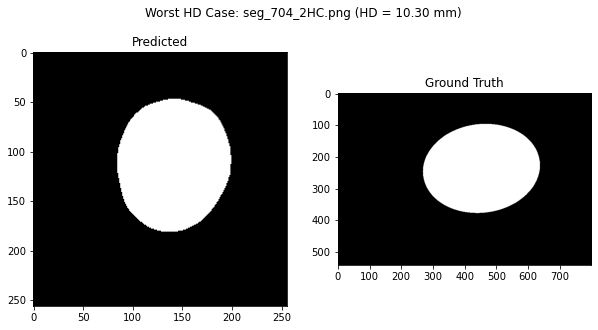

In [22]:
import matplotlib.pyplot as plt

def plot_outlier(pred_dir, gt_dir, worst_file):
    base_name = worst_file.replace("seg_", "").replace(".png", "")
    gt_file = base_name + "_Annotation.png"

    pred_mask = cv2.imread(os.path.join(pred_dir, worst_file), cv2.IMREAD_GRAYSCALE)
    gt_mask = cv2.imread(os.path.join(gt_dir, gt_file), cv2.IMREAD_GRAYSCALE)

    plt.figure(figsize=(10, 5))
    plt.subplot(121), plt.imshow(pred_mask, cmap='gray'), plt.title("Predicted")
    plt.subplot(122), plt.imshow(gt_mask, cmap='gray'), plt.title("Ground Truth")
    plt.suptitle(f"Worst HD Case: {worst_file} (HD = 10.30 mm)")
    plt.show()

plot_outlier(pred_dir, gt_dir, "seg_704_2HC.png")

**Morphological Opening and Closing + Canny edge Detector**

Processed and saved edge image for: seg_608_HC.png
Processed and saved edge image for: seg_646_HC.png
Processed and saved edge image for: seg_517_HC.png
Processed and saved edge image for: seg_631_HC.png
Processed and saved edge image for: seg_669_HC.png
Processed and saved edge image for: seg_676_HC.png
Processed and saved edge image for: seg_665_HC.png
Processed and saved edge image for: seg_648_2HC.png
Processed and saved edge image for: seg_639_HC.png
Processed and saved edge image for: seg_592_HC.png
Processed and saved edge image for: seg_570_3HC.png
Processed and saved edge image for: seg_528_HC.png
Processed and saved edge image for: seg_560_HC.png
Processed and saved edge image for: seg_593_HC.png
Processed and saved edge image for: seg_520_HC.png
Processed and saved edge image for: seg_584_HC.png
Processed and saved edge image for: seg_610_HC.png
Processed and saved edge image for: seg_567_2HC.png
Processed and saved edge image for: seg_707_HC.png
Processed and saved edge ima

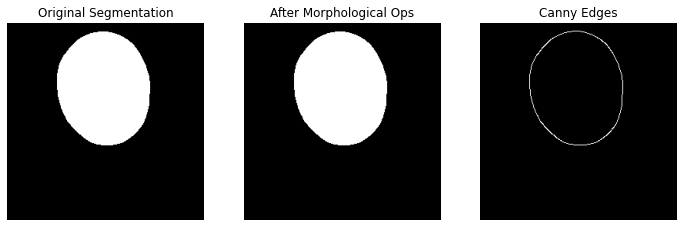

Processed and saved edge image for: seg_706_HC.png
Processed and saved edge image for: seg_640_HC.png
Processed and saved edge image for: seg_637_HC.png
Processed and saved edge image for: seg_630_2HC.png
Processed and saved edge image for: seg_674_HC.png
Processed and saved edge image for: seg_643_HC.png
Processed and saved edge image for: seg_554_HC.png
Processed and saved edge image for: seg_609_2HC.png
Processed and saved edge image for: seg_650_HC.png
Processed and saved edge image for: seg_691_HC.png
Processed and saved edge image for: seg_585_HC.png
Processed and saved edge image for: seg_651_HC.png
Processed and saved edge image for: seg_653_HC.png
Processed and saved edge image for: seg_556_HC.png
Processed and saved edge image for: seg_599_HC.png
Processed and saved edge image for: seg_624_HC.png
Processed and saved edge image for: seg_681_HC.png
Processed and saved edge image for: seg_678_HC.png
Processed and saved edge image for: seg_594_HC.png
Processed and saved edge imag

In [14]:
import cv2
import numpy as np
import os
import matplotlib.pyplot as plt
import random

# Define input and output folders
input_folder = 'output_segmentations'
output_folder = 'output_edges'
os.makedirs(output_folder, exist_ok=True)

# Define a structuring element for the morphological operations
kernel = np.ones((5, 5), np.uint8)

# Get list of all .png files
image_files = [f for f in os.listdir(input_folder) if f.endswith('.png')]

# Randomly select one file to display
display_image = random.choice(image_files)

# Loop over all segmented images in the input folder
for filename in image_files:
    img_path = os.path.join(input_folder, filename)
    seg_img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)

    # Morphological opening to remove small artifacts
    opened = cv2.morphologyEx(seg_img, cv2.MORPH_OPEN, kernel)
    # Morphological closing to fill small holes
    closed = cv2.morphologyEx(opened, cv2.MORPH_CLOSE, kernel)

    # Canny edge detection
    edges = cv2.Canny(closed, 50, 150)

    # Save edge image
    output_path = os.path.join(output_folder, filename)
    cv2.imwrite(output_path, edges)

    # Show only the selected random image
    if filename == display_image:
        plt.figure(figsize=(12, 4))

        plt.subplot(1, 3, 1)
        plt.imshow(seg_img, cmap='gray')
        plt.title('Original Segmentation')
        plt.axis('off')

        plt.subplot(1, 3, 2)
        plt.imshow(closed, cmap='gray')
        plt.title('After Morphological Ops')
        plt.axis('off')

        plt.subplot(1, 3, 3)
        plt.imshow(edges, cmap='gray')
        plt.title('Canny Edges')
        plt.axis('off')

        plt.show()

    print(f"Processed and saved edge image for: {filename}")

In [31]:
# import os
# import cv2
# import numpy as np
# import csv
# import math
# from PIL import Image

# # -------------------------------
# # Parameters
# # -------------------------------
# resized_dim    = 256                          # dimension used in preprocessing/inference
# seg_folder     = 'output_segmentations'       # folder with cleaned segmentation masks
# orig_folder    = 'denoised_test_set'         # folder with original test images
# pixel_csv      = 'test_set_pixel_size.csv'    # CSV mapping filename to pixel size (mm)
# output_csv     = 'ellipse_parameters2.csv'     # output CSV for ellipse params

# # -------------------------------
# # Step 1: Load pixel size info
# # -------------------------------
# pixel_size_dict = {}
# with open(pixel_csv, mode='r') as f:
#     reader = csv.DictReader(f)
#     for row in reader:
#         pixel_size_dict[row['filename']] = float(row['pixel size(mm)'])

# # -------------------------------
# # Step 2: Prepare CSV output
# # -------------------------------
# header = ["filename",
#           "center_x_mm",
#           "center_y_mm",
#           "semi_axes_a_mm",
#           "semi_axes_b_mm",
#           "angle_rad"]
# rows = []

# # Structuring element for morphology
# kernel = np.ones((5, 5), np.uint8)

# # -------------------------------
# # Step 3: Loop over segmentation masks
# # -------------------------------
# for fname in sorted(os.listdir(seg_folder)):
#     if not fname.lower().endswith('.png'):
#         continue

#     seg_path = os.path.join(seg_folder, fname)
#     seg_img = cv2.imread(seg_path, cv2.IMREAD_GRAYSCALE)
#     if seg_img is None:
#         print(f"Failed to load {fname}")
#         continue

#     # Morphological open & close
#     opened = cv2.morphologyEx(seg_img, cv2.MORPH_OPEN, kernel)
#     closed = cv2.morphologyEx(opened, cv2.MORPH_CLOSE, kernel)
    
#     smooth = cv2.GaussianBlur(closed, (5,5), sigmaX=1)
#     _, closed = cv2.threshold(smooth, 127, 255, cv2.THRESH_BINARY)
#     # then findContours(closed) → fitEllipse(...)


#     # Find contours on the cleaned mask
#     contours, _ = cv2.findContours(closed, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_NONE)
#     if not contours:
#         print(f"No contours in {fname}")
#         continue

#     cnt = max(contours, key=cv2.contourArea)
#     if len(cnt) < 5:
#         print(f"Too few contour points in {fname}")
#         continue

    
#     # Fit ellipse
#     ellipse = cv2.fitEllipse(cnt)
#     (cx, cy), (full_a, full_b), angle_deg = ellipse

#     # Convert axes to semi-axes in resized space
#     semi_a_resized = full_a / 2.0
#     semi_b_resized = full_b / 2.0

#     # -------------------------------
#     # Step 4: Map back to original image size
#     # -------------------------------
#     base_fn = fname.replace("seg_", "", 1)
#     orig_path = os.path.join(orig_folder, base_fn)
#     if not os.path.exists(orig_path):
#         print(f"Original image missing: {base_fn}")
#         continue

#     with Image.open(orig_path) as im:
#         orig_w, orig_h = im.size

#     scale_x = orig_w / float(resized_dim)
#     scale_y = orig_h / float(resized_dim)

#     cx_orig = cx * scale_x
#     cy_orig = cy * scale_y
#     a_orig  = semi_a_resized * scale_x
#     b_orig  = semi_b_resized * scale_y

#     # -------------------------------
#     # Step 5: Convert to millimeters
#     # -------------------------------
#     if base_fn not in pixel_size_dict:
#         print(f"Missing pixel size for {base_fn}")
#         continue
#     px2mm = pixel_size_dict[base_fn]

#     cx_mm = cx_orig * px2mm
#     cy_mm = cy_orig * px2mm
#     a_mm  = a_orig  * px2mm
#     b_mm  = b_orig  * px2mm
#     angle_rad = math.radians(angle_deg)

#     rows.append([base_fn, cx_mm, cy_mm, a_mm, b_mm, angle_rad])

# # -------------------------------
# # Step 6: Write CSV
# # -------------------------------
# with open(output_csv, mode='w', newline='') as f:
#     writer = csv.writer(f)
#     writer.writerow(header)
#     writer.writerows(rows)

# print(f"Saved ellipse parameters for {len(rows)} images to '{output_csv}'.")

Saved ellipse parameters for 250 images to 'ellipse_parameters2.csv'.


**Morphological Opening and Closing + Canny edge Detector on filled annotations for MHD (Mean Hausdorff Distance)**

In [25]:
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt

# Define input folder for the filled annotations and the output folder for the processed annotations
input_folder = 'masked_annotations_test'  # Folder with filled ground truth annotations, e.g., "500_HC_Annotation.png"
output_folder = 'postprocessing_annotations'
os.makedirs(output_folder, exist_ok=True)

# Define a structuring element for the morphological operations (same as used on the predictions)
kernel = np.ones((5, 5), np.uint8)
resized_dim = 256

# Loop over all annotation images in the input folder
for filename in os.listdir(input_folder):
    if filename.endswith('.png'):
        img_path = os.path.join(input_folder, filename)
        # Read the filled annotation image in grayscale
        annotation_img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
        annotation_img = cv2.resize(
            annotation_img,
            (resized_dim, resized_dim),
            interpolation=cv2.INTER_NEAREST
        )
        
        # Apply morphological opening (erosion followed by dilation) to remove small artifacts
        opened = cv2.morphologyEx(annotation_img, cv2.MORPH_OPEN, kernel)
        # Then apply morphological closing (dilation followed by erosion) to fill small holes
        closed = cv2.morphologyEx(opened, cv2.MORPH_CLOSE, kernel)
        
        # Apply Canny edge detector to extract the boundary
        # Adjust thresholds if necessary; here using 50 and 150 as example values
        edges = cv2.Canny(closed, 50, 150)
        
        # Save the processed (edge-detected) annotation image
        output_path = os.path.join(output_folder, filename)
        cv2.imwrite(output_path, edges)
        
        # Optionally display the images side by side
        # plt.figure(figsize=(12, 4))
        # plt.subplot(1, 3, 1)
        # plt.imshow(annotation_img, cmap='gray')
        # plt.title('Original Annotation')
        # plt.axis('off')
        #
        # plt.subplot(1, 3, 2)
        # plt.imshow(closed, cmap='gray')
        # plt.title('After Morphological Ops')
        # plt.axis('off')
        #
        # plt.subplot(1, 3, 3)
        # plt.imshow(edges, cmap='gray')
        # plt.title('Canny Edges')
        # plt.axis('off')
        #
        # plt.show()
        
        print(f"Processed and saved edge image for: {filename}")

Processed and saved edge image for: 531_2HC_Annotation.png
Processed and saved edge image for: 586_HC_Annotation.png
Processed and saved edge image for: 669_HC_Annotation.png
Processed and saved edge image for: 587_HC_Annotation.png
Processed and saved edge image for: 695_HC_Annotation.png
Processed and saved edge image for: 516_HC_Annotation.png
Processed and saved edge image for: 569_HC_Annotation.png
Processed and saved edge image for: 520_HC_Annotation.png
Processed and saved edge image for: 621_HC_Annotation.png
Processed and saved edge image for: 617_2HC_Annotation.png
Processed and saved edge image for: 591_HC_Annotation.png
Processed and saved edge image for: 653_HC_Annotation.png
Processed and saved edge image for: 566_2HC_Annotation.png
Processed and saved edge image for: 506_HC_Annotation.png
Processed and saved edge image for: 577_HC_Annotation.png
Processed and saved edge image for: 613_3HC_Annotation.png
Processed and saved edge image for: 570_HC_Annotation.png
Processed 

Processed and saved edge image for: 626_HC_Annotation.png
Processed and saved edge image for: 543_HC_Annotation.png
Processed and saved edge image for: 639_HC_Annotation.png
Processed and saved edge image for: 614_HC_Annotation.png
Processed and saved edge image for: 556_2HC_Annotation.png
Processed and saved edge image for: 532_HC_Annotation.png
Processed and saved edge image for: 699_HC_Annotation.png
Processed and saved edge image for: 679_HC_Annotation.png
Processed and saved edge image for: 570_3HC_Annotation.png
Processed and saved edge image for: 587_2HC_Annotation.png
Processed and saved edge image for: 705_HC_Annotation.png
Processed and saved edge image for: 528_HC_Annotation.png
Processed and saved edge image for: 556_HC_Annotation.png
Processed and saved edge image for: 542_HC_Annotation.png
Processed and saved edge image for: 675_2HC_Annotation.png
Processed and saved edge image for: 644_HC_Annotation.png
Processed and saved edge image for: 541_2HC_Annotation.png
Processed

**MHD (Mean Hausdorff Distance)**

In [30]:
import csv
import os
import cv2
import numpy as np
from scipy.spatial.distance import directed_hausdorff
from PIL import Image
from scipy.spatial.distance import cdist


# ------------------------------------------------------------
# Step 1: Load the CSV file with pixel size info.
# ------------------------------------------------------------
# The CSV (test_set_pixel_size.csv) is assumed to have columns "filename" and "pixel size(mm)"
# where the filename corresponds to the original test image (e.g., "500_HC.png").
pixel_size_dict = {}
csv_file = 'test_set_pixel_size.csv'
with open(csv_file, mode='r') as f:
    reader = csv.DictReader(f)
    for row in reader:
        filename_csv = row['filename']  # e.g., "500_HC.png"
        pixel_size_mm = float(row['pixel size(mm)'])
        pixel_size_dict[filename_csv] = pixel_size_mm

# ------------------------------------------------------------
# Set the resized dimension used in your inference pipeline.
# ------------------------------------------------------------
resized_dim = 256  # All images are resized to 256x256 during preprocessing/inference

# ------------------------------------------------------------
# Step 2: Define function to compute Hausdorff distance with coordinate transformation.
# ------------------------------------------------------------
def hausdorff_distance_transformed(pred_edges, true_edges, scale_x, scale_y):
    """
    Computes the Hausdorff distance between two edge images after transforming
    the coordinates from the resized (256x256) space to the original image space.
    
    Args:
        pred_edges (np.array): Predicted edge image in 256x256 space (uint8),
                               with edges as nonzero (e.g., 255).
        true_edges (np.array): Ground truth edge image in 256x256 space (uint8).
        scale_x (float): Factor to convert x coordinates.
        scale_y (float): Factor to convert y coordinates.
        
    Returns:
        float: Hausdorff distance in pixel units (in the original image space).
    """
    # np.where returns (rows, cols) which are (y, x)
    pred_points = np.column_stack(np.where(pred_edges != 0))
    true_points = np.column_stack(np.where(true_edges != 0))
    
    if pred_points.size == 0 or true_points.size == 0:
        return np.nan  # Return NaN if no edges are found in one of the images.
    
    # Transform predicted points from resized space to original space.
    pred_points_transformed = np.zeros_like(pred_points, dtype=np.float32)
    pred_points_transformed[:, 0] = pred_points[:, 0] * scale_y  # y coordinate
    pred_points_transformed[:, 1] = pred_points[:, 1] * scale_x  # x coordinate
    
    # Similarly, transform ground truth points.
    true_points_transformed = np.zeros_like(true_points, dtype=np.float32)
    true_points_transformed[:, 0] = true_points[:, 0] * scale_y
    true_points_transformed[:, 1] = true_points[:, 1] * scale_x
    
    d1 = directed_hausdorff(pred_points_transformed, true_points_transformed)[0]
    d2 = directed_hausdorff(true_points_transformed, pred_points_transformed)[0]
    return max(d1, d2)


def mean_hausdorff_distance_transformed(pred_edges, true_edges, scale_x, scale_y):
    """
    Computes the Mean Hausdorff Distance (MHD) between two edge images after coordinate transformation.
    """
    pred_points = np.column_stack(np.where(pred_edges != 0))
    true_points = np.column_stack(np.where(true_edges != 0))
    
    if pred_points.size == 0 or true_points.size == 0:
        return np.nan
    
    # Transform points to original image space
    pred_points_transformed = pred_points * np.array([scale_y, scale_x])
    true_points_transformed = true_points * np.array([scale_y, scale_x])
    
    # Compute MHD
    dist_matrix = cdist(pred_points_transformed, true_points_transformed, 'euclidean')
    min_dists_pred_to_true = np.min(dist_matrix, axis=1)
    min_dists_true_to_pred = np.min(dist_matrix, axis=0)
    mhd = np.mean(np.concatenate([min_dists_pred_to_true, min_dists_true_to_pred]))
    
    return mhd

# ------------------------------------------------------------
# Step 3: Set directories for predicted edge images, ground truth boundary annotations,
#         and the original test images.
# ------------------------------------------------------------
pred_edge_dir = 'output_edges'                  # Predicted edge images (resized: 256x256)
gt_edge_dir = 'postprocessing_annotations'        # Ground truth boundaries (resized: 256x256)
orig_image_dir = 'denoised_test_set'              # Original test images (actual dimensions), e.g., "500_HC.png"

# ------------------------------------------------------------
# Step 4: Loop over predicted edge files, compute dynamic scaling, then compute MHD.
# ------------------------------------------------------------
pred_files = sorted([f for f in os.listdir(pred_edge_dir) if f.endswith('.png')])
hd_scores_mm = []  # To store Hausdorff distances in millimeters
hd_scores_mm_std = []

for pred_file in pred_files:
    pred_path = os.path.join(pred_edge_dir, pred_file)
    
    # Derive the base filename. For example, if the predicted file is "seg_500_HC.png",
    # remove the "seg_" prefix to get "500_HC.png".
    base_filename = pred_file.replace("seg_", "", 1)  # e.g., "500_HC.png"
    
    # Build the key for CSV lookup (should match the original image filename)
    csv_key = base_filename  # e.g., "500_HC.png"
    if csv_key not in pixel_size_dict:
        print(f"No pixel size found for {csv_key}; skipping {pred_file}.")
        continue
    pixel_to_mm = pixel_size_dict[csv_key]
    
    # Get the corresponding original test image from orig_image_dir.
    orig_img_path = os.path.join(orig_image_dir, base_filename)
    if not os.path.exists(orig_img_path):
        print(f"Original image {base_filename} not found; skipping {pred_file}.")
        continue
    with Image.open(orig_img_path) as img:
        orig_width, orig_height = img.size  # Dynamically retrieve original dimensions
    
    # Compute scale factors for this image:
    scale_x = orig_width / float(resized_dim)
    scale_y = orig_height / float(resized_dim)
    
    # Construct the corresponding ground truth (boundary) filename.
    gt_file = base_filename.replace(".png", "_Annotation.png")  # e.g., "500_HC_Annotation.png"
    gt_path = os.path.join(gt_edge_dir, gt_file)
    if not os.path.exists(gt_path):
        print(f"Ground truth file {gt_file} not found for {pred_file}; skipping.")
        continue
    
    # Load predicted and ground truth edge images in grayscale (both should be 256x256)
    pred_edges = cv2.imread(pred_path, cv2.IMREAD_GRAYSCALE)
    true_edges = cv2.imread(gt_path, cv2.IMREAD_GRAYSCALE)
    if pred_edges is None or true_edges is None:
        print(f"Error loading {pred_file} or {gt_file}; skipping.")
        continue
    
    # Compute Hausdorff distance in pixel units (transformed to original image coordinate space)
    hd_pixels = mean_hausdorff_distance_transformed(pred_edges, true_edges, scale_x, scale_y)
    hd_pixels_std = hausdorff_distance_transformed(pred_edges, true_edges, scale_x, scale_y)
    if np.isnan(hd_pixels):
        print(f"No edges found in one of the images for {pred_file}; skipping.")
        continue
    
    # Convert the Hausdorff distance from original pixel units to millimeters.
    hd_mm = hd_pixels * pixel_to_mm
    hd_scores_mm.append(hd_mm)
    
    hd_mm_std = hd_pixels_std * pixel_to_mm
    hd_scores_mm_std.append(hd_mm_std)

# ------------------------------------------------------------
# Step 5: Compute and print overall Mean Hausdorff Distance in mm.
# ------------------------------------------------------------
mean_hd_mm = np.nanmean(hd_scores_mm)
mean_hd_mm_std = np.nanmean(hd_scores_mm_std)
print("Mean Hausdorff Distance (MHD): {:.4f} mm".format(mean_hd_mm))
print("Standard Hausdorff Distance (HD): {:.4f} mm".format(mean_hd_mm_std))

Mean Hausdorff Distance (MHD): 0.6096 mm
Standard Hausdorff Distance (HD): 1.8518 mm


**Ellipse fiting**

In [27]:
#     import csv
#     import cv2
#     import numpy as np
#     import os
#     import math

#     # --- Step 1: Load the pixel size information from the CSV file ---
#     # Assume your CSV file 'test_set_pixel_size.csv' has at least these columns:
#     # filename,pixel_size_mm
#     pixel_size_dict = {}
#     with open('test_set_pixel_size.csv', mode='r') as f:
#         reader = csv.DictReader(f)
#         for row in reader:
#             # Adjust the column names if they are different in your CSV file.
#             filename_csv = row['filename']
#             pixel_size_mm = float(row['pixel size(mm)'])
#             pixel_size_dict[filename_csv] = pixel_size_mm

#     # --- Step 2: Process the edge images and fit ellipses ---
#     edges_folder = 'output_edges'
#     csv_output = 'ellipse_results.csv'
#     header = ["filename", "center_x_mm", "center_y_mm", "semi_axes_a_mm", "semi_axes_b_mm", "angle_rad"]
#     rows = []

#     for filename in sorted(os.listdir(edges_folder)):
#         if filename.endswith('.png'):
#             filepath = os.path.join(edges_folder, filename)
#             # Read the edge image in grayscale
#             edge_img = cv2.imread(filepath, cv2.IMREAD_GRAYSCALE)

#             # Find contours in the edge image
#             contours, _ = cv2.findContours(edge_img, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
#             if len(contours) == 0:
#                 print(f"No contours found in {filename}. Skipping.")
#                 continue

#             # Choose the largest contour (assumed to be the head contour)
#             largest_contour = max(contours, key=cv2.contourArea)

#             # cv2.fitEllipse requires at least 5 points
#             if len(largest_contour) < 5:
#                 print(f"Not enough points for ellipse fitting in {filename}. Skipping.")
#                 continue

#             # Fit ellipse to the largest contour
#             ellipse = cv2.fitEllipse(largest_contour)
#             # ellipse returns ((center_x, center_y), (full_axis_length_a, full_axis_length_b), angle_in_degrees)
#             center, axes, angle = ellipse
#             # Compute semi-axes (the axes given are the full lengths)
#             semi_a = axes[0] / 2.0  # semi-major axis in pixels
#             semi_b = axes[1] / 2.0  # semi-minor axis in pixels

#             # --- Step 3: Look up the pixel conversion factor for this image ---
#             # The filenames in the CSV are expected to be like "001_HC.png"
#             # and our edge images are named "seg_001_HC.png". Remove the "seg_" prefix.
#             base_filename = filename.replace("seg_", "", 1)
#             if base_filename in pixel_size_dict:
#                 pixel_to_mm = pixel_size_dict[base_filename]
#             else:
#                 print(f"Pixel size for {base_filename} not found in CSV. Skipping.")
#                 continue

#             # Convert measurements from pixels to millimeters
#             center_x_mm = center[0] * pixel_to_mm
#             center_y_mm = center[1] * pixel_to_mm
#             semi_a_mm = semi_a * pixel_to_mm
#             semi_b_mm = semi_b * pixel_to_mm

#             # Convert angle from degrees to radians
#             angle_rad = math.radians(angle)

#             # Append the result: filename, center_x_mm, center_y_mm, semi_axes_a_mm, semi_axes_b_mm, angle_rad
#             rows.append([base_filename, center_x_mm, center_y_mm, semi_a_mm, semi_b_mm, angle_rad])

#     # --- Step 4: Write results to a CSV file ---
#     with open(csv_output, mode='w', newline='') as file:
#         writer = csv.writer(file)
#         writer.writerow(header)
#         writer.writerows(rows)

#     print(f"CSV file '{csv_output}' saved with {len(rows)} rows.")

In [28]:
# import csv
# import cv2
# import numpy as np
# import os
# import math

# # ------------------------------------------------------------
# # Define original image dimensions and resized dimensions
# # ------------------------------------------------------------
# original_width = 800    # original image width in pixels
# original_height = 540   # original image height in pixels
# resized_dim = 256       # both width and height after resizing

# # Compute scale factors for converting from the resized space to the original space:
# scale_x = original_width / float(resized_dim)   # e.g., 800/256
# scale_y = original_height / float(resized_dim)  # e.g., 540/256

# # ------------------------------------------------------------
# # Step 1: Load the pixel size information from the CSV file
# # ------------------------------------------------------------
# # The CSV (test_set_pixel_size.csv) is assumed to have columns "filename" and "pixel size(mm)" 
# # where the filename is based on the original image (e.g., "001_HC.png").
# pixel_size_dict = {}
# csv_file = 'test_set_pixel_size.csv'
# with open(csv_file, mode='r') as f:
#     reader = csv.DictReader(f)
#     for row in reader:
#         filename_csv = row['filename']  # e.g., "001_HC.png"
#         pixel_size_mm = float(row['pixel size(mm)'])
#         pixel_size_dict[filename_csv] = pixel_size_mm

# # ------------------------------------------------------------
# # Step 2: Process the edge images (from output_edges folder) and fit ellipses.
# #         Note: These edge images are produced from images resized to 256x256.
# # ------------------------------------------------------------
# edges_folder = 'output_edges'
# csv_output = 'ellipse_results.csv'
# header = ["filename", "center_x_mm", "center_y_mm", "semi_axes_a_mm", "semi_axes_b_mm", "angle_rad"]
# rows = []

# for filename in sorted(os.listdir(edges_folder)):
#     if filename.endswith('.png'):
#         filepath = os.path.join(edges_folder, filename)
#         # Read the edge image in grayscale (should be 256x256)
#         edge_img = cv2.imread(filepath, cv2.IMREAD_GRAYSCALE)
#         if edge_img is None:
#             print(f"Error loading {filename}; skipping.")
#             continue

#         # Find contours in the edge image
#         contours, _ = cv2.findContours(edge_img, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
#         if len(contours) == 0:
#             print(f"No contours found in {filename}. Skipping.")
#             continue
        
#         # Choose the largest contour (assumed to be the head contour)
#         largest_contour = max(contours, key=cv2.contourArea)
        
#         # cv2.fitEllipse requires at least 5 points
#         if len(largest_contour) < 5:
#             print(f"Not enough points for ellipse fitting in {filename}. Skipping.")
#             continue
        
#         # Fit ellipse to the largest contour
#         ellipse = cv2.fitEllipse(largest_contour)
#         # ellipse returns ((center_x, center_y), (full_axis_length_a, full_axis_length_b), angle_in_degrees)
#         center, axes, angle = ellipse
#         # Compute semi-axes in the resized coordinate space
#         semi_a_resized = axes[0] / 2.0
#         semi_b_resized = axes[1] / 2.0

#         # Scale the center and semi-axes from resized (256x256) to original image coordinate space
#         center_x_original = center[0] * scale_x
#         center_y_original = center[1] * scale_y
#         semi_a_original = semi_a_resized * scale_x
#         semi_b_original = semi_b_resized * scale_y

#         # --- Step 3: Look up the pixel-to-mm conversion factor for this image ---
#         # The CSV expects file names like "001_HC.png"; our predictions are named "seg_001_HC.png"
#         base_filename = filename.replace("seg_", "", 1)  # e.g., "001_HC.png"
#         if base_filename in pixel_size_dict:
#             pixel_to_mm = pixel_size_dict[base_filename]
#         else:
#             print(f"Pixel size for {base_filename} not found in CSV. Skipping.")
#             continue

#         # Convert measurements from original pixel space to millimeters
#         center_x_mm = center_x_original * pixel_to_mm
#         center_y_mm = center_y_original * pixel_to_mm
#         semi_a_mm = semi_a_original * pixel_to_mm
#         semi_b_mm = semi_b_original * pixel_to_mm

#         # Convert angle from degrees to radians
#         angle_rad = math.radians(angle)

#         # Append the result
#         rows.append([base_filename, center_x_mm, center_y_mm, semi_a_mm, semi_b_mm, angle_rad])

# # ------------------------------------------------------------
# # Step 4: Write results to a CSV file
# # ------------------------------------------------------------
# with open(csv_output, mode='w', newline='') as file:
#     writer = csv.writer(file)
#     writer.writerow(header)
#     writer.writerows(rows)

# print(f"CSV file '{csv_output}' saved with {len(rows)} rows.")

In [29]:
import csv
import cv2
import numpy as np
import os
import math
from PIL import Image

# ------------------------------------------------------------
# Define resized dimension (from your on-the-fly augmentation)
# ------------------------------------------------------------
resized_dim = 256  # images are resized to 256x256 during preprocessing/inference

# ------------------------------------------------------------
# Step 1: Load the pixel size information from the CSV file
# ------------------------------------------------------------
# The CSV (test_set_pixel_size.csv) is assumed to have columns "filename" and "pixel size(mm)"
# where the filename is based on the original test image (e.g., "500_HC.png").
pixel_size_dict = {}
csv_file = 'test_set_pixel_size.csv'
with open(csv_file, mode='r') as f:
    reader = csv.DictReader(f)
    for row in reader:
        filename_csv = row['filename']  # e.g., "500_HC.png"
        pixel_size_mm = float(row['pixel size(mm)'])
        pixel_size_dict[filename_csv] = pixel_size_mm

# ------------------------------------------------------------
# Folder for original test images (to retrieve dynamic dimensions)
# ------------------------------------------------------------
orig_image_dir = 'denoised_test_set'  # Test images are stored here (e.g., "500_HC.png")

# ------------------------------------------------------------
# Step 2: Process the edge images (from output_edges folder) and fit ellipses.
#         Note: These edge images are produced from images resized to 256x256.
# ------------------------------------------------------------
edges_folder = 'output_edges'
csv_output = 'ellipse_results.csv'
header = ["filename", "center_x_mm", "center_y_mm", "semi_axes_a_mm", "semi_axes_b_mm", "angle_rad"]
rows = []

for filename in sorted(os.listdir(edges_folder)):
    if filename.endswith('.png'):
        filepath = os.path.join(edges_folder, filename)
        # Read the edge image in grayscale (expected size: 256x256)
        edge_img = cv2.imread(filepath, cv2.IMREAD_GRAYSCALE)
        if edge_img is None:
            print(f"Error loading {filename}; skipping.")
            continue

        # Find contours in the edge image
        contours, _ = cv2.findContours(edge_img, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
        if len(contours) == 0:
            print(f"No contours found in {filename}. Skipping.")
            continue
        
        # Choose the largest contour (assumed to be the head contour)
        largest_contour = max(contours, key=cv2.contourArea)
        
        # cv2.fitEllipse requires at least 5 points
        if len(largest_contour) < 5:
            print(f"Not enough points for ellipse fitting in {filename}. Skipping.")
            continue
        
        # Fit ellipse to the largest contour
        ellipse = cv2.fitEllipse(largest_contour)
        # ellipse returns ((center_x, center_y), (full_axis_length_a, full_axis_length_b), angle_in_degrees)
        center, axes, angle = ellipse
        # Compute semi-axes in the resized coordinate space
        semi_a_resized = axes[0] / 2.0
        semi_b_resized = axes[1] / 2.0

        # ------------------------------------------------------------
        # Step 3: Dynamically determine the original image dimensions.
        # ------------------------------------------------------------
        # The predictions are based on images that were resized from the original.
        # For a given predicted file, its base name (e.g., "500_HC.png") is used to find the corresponding original image.
        # For test data, the predicted file is likely named "seg_500_HC.png" (if using the same prefix convention).
        base_filename = filename.replace("seg_", "", 1)  # e.g., "500_HC.png"
        orig_img_path = os.path.join(orig_image_dir, base_filename)
        if not os.path.exists(orig_img_path):
            print(f"Original test image {base_filename} not found; skipping {filename}.")
            continue
        with Image.open(orig_img_path) as img:
            orig_width, orig_height = img.size  # (width, height)

        # Compute scale factors for this image from the resized dimension to its original dimensions.
        scale_x = orig_width / float(resized_dim)
        scale_y = orig_height / float(resized_dim)
        
        # ------------------------------------------------------------
        # Step 4: Scale the ellipse parameters from the resized (256x256) space back to the original space.
        # ------------------------------------------------------------
        center_x_original = center[0] * scale_x
        center_y_original = center[1] * scale_y
        semi_a_original = semi_a_resized * scale_x
        semi_b_original = semi_b_resized * scale_y

        # ------------------------------------------------------------
        # Step 5: Look up the pixel-to-mm conversion factor for this image.
        # The CSV expects file names like "500_HC.png"; our base_filename should match.
        # ------------------------------------------------------------
        if base_filename in pixel_size_dict:
            pixel_to_mm = pixel_size_dict[base_filename]
        else:
            print(f"Pixel size for {base_filename} not found in CSV. Skipping.")
            continue

        # Convert the measurements from original pixel space to millimeters.
        center_x_mm = center_x_original * pixel_to_mm
        center_y_mm = center_y_original * pixel_to_mm
        semi_a_mm = semi_a_original * pixel_to_mm
        semi_b_mm = semi_b_original * pixel_to_mm

        # Convert angle from degrees to radians
        angle_rad = math.radians(angle)

        # Append the results: filename, center_x_mm, center_y_mm, semi_axes_a_mm, semi_axes_b_mm, angle_rad
        rows.append([base_filename, center_x_mm, center_y_mm, semi_a_mm, semi_b_mm, angle_rad])

# ------------------------------------------------------------
# Step 6: Write results to a CSV file
# ------------------------------------------------------------
with open(csv_output, mode='w', newline='') as file:
    writer = csv.writer(file)
    writer.writerow(header)
    writer.writerows(rows)

print(f"CSV file '{csv_output}' saved with {len(rows)} rows.")

CSV file 'ellipse_results.csv' saved with 250 rows.
